<a href="https://www.kaggle.com/code/mohammedmohsen0404/proj26-cv-food-image-classification?scriptVersionId=194474061" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

---
**<center><h1>Food Image Classification</h1></center>**
<center><h3>Learning ML, DL through 100 Practical Projects</h3></center>

---

This project aims to leverage the dataset of 16,643 food images, organized into 11 major food categories, to develop and refine food classification models. By utilizing the evaluation, training, and validation splits provided, the goal is to build a robust model capable of accurately identifying and categorizing different food types. This work is intended to enhance food recognition systems and contribute to applications in areas such as dietary tracking and food-related artificial intelligence.

# **Import Libraries and Data**
---

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Conv2D , MaxPooling2D , Dropout , Flatten , Activation , BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img
from sklearn.metrics import classification_report, confusion_matrix, f1_score

2024-08-28 20:31:20.788812: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 20:31:20.788928: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 20:31:20.958427: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d trolukovich/food11-image-dataset     #change
!unzip -q food11-image-dataset.zip -d food11-image-dataset

cp: cannot stat '/content/drive/MyDrive/kaggle/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/trolukovich/food11-image-dataset
License(s): CC0-1.0
 98%|██████████████████████████████████████▍| 1.07G/1.08G [00:06<00:00, 215MB/s]
100%|███████████████████████████████████████| 1.08G/1.08G [00:06<00:00, 167MB/s]


In [4]:
import os
import pandas as pd

def create_data(path):
    label = []
    data = []
    # Get list of folders in path
    folder = os.listdir(path)
    for i in folder:
        # Create full path of the folder
        folder_path = os.path.join(path, i)
        # Create list of files in folders
        folder_list = os.listdir(folder_path)
        # Iterate through each file in the folder
        for file in folder_list:
            # Create full path to the file
            file_path = os.path.join(folder_path, file)
            label.append(i)
            data.append(file_path)
    # Convert list (label, data) to pandas dataframe
    data_path = pd.Series(data, name='filepath')
    label = pd.Series(label, name='label')
    return pd.concat([data_path, label], axis=1)

def load_data():
    base_dir = 'food11-image-dataset'  # Adjust the path if necessary
    training_path = os.path.join(base_dir, 'training')
    validation_path = os.path.join(base_dir, 'validation')
    evaluation_path = os.path.join(base_dir, 'evaluation')

    train_data = create_data(training_path)
    val_data = create_data(validation_path)
    eval_data = create_data(evaluation_path)

    return train_data, val_data, eval_data

train_data, val_data, eval_data = load_data()

# Display first few rows of the training data
train_data.head()


filepath label
0  food11-image-dataset/training/Egg/223.jpg   Egg
1  food11-image-dataset/training/Egg/553.jpg   Egg
2  food11-image-dataset/training/Egg/275.jpg   Egg
3  food11-image-dataset/training/Egg/946.jpg   Egg
4  food11-image-dataset/training/Egg/794.jpg   Egg

In [5]:
print(train_data.shape)
print(val_data.shape)
print(eval_data.shape)

(9866, 2)
(3430, 2)
(3347, 2)


# **Data Preparation**
----

In [6]:
# parameters
image_size = 128
image_channel = 3
bat_size = 32

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range = 15,
                                    horizontal_flip = True,
                                    zoom_range = 0.2,
                                    shear_range = 0.1,
                                    fill_mode = 'reflect',
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1)


test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_dataframe(train_data,
                                                    x_col= 'filepath',
                                                    y_col= 'label',
                                                    batch_size = bat_size,
                                                    target_size = (image_size,image_size)
                                                   )
val_generator = test_datagen.flow_from_dataframe(val_data, 
                                                 x_col= 'filepath',
                                                 y_col= 'label',
                                                 batch_size = bat_size,
                                                 target_size = (image_size,image_size),
                                                 shuffle=False
                                                )

test_generator = test_datagen.flow_from_dataframe(eval_data, 
                                                  x_col= 'filepath',
                                                  y_col= 'label',
                                                  batch_size = bat_size,
                                                  target_size = (image_size,image_size),
                                                  shuffle=False
                                                 )

Found 9866 validated image filenames belonging to 11 classes.
Found 3430 validated image filenames belonging to 11 classes.
Found 3347 validated image filenames belonging to 11 classes.


# **Data Exploration**
----

In [9]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Classes present in datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Classes present in datasets

0 : Bread
1 : Dairy product
2 : Dessert
3 : Egg
4 : Fried food
5 : Meat
6 : Noodles-Pasta
7 : Rice
8 : Seafood
9 : Soup
10 : Vegetable-Fruit


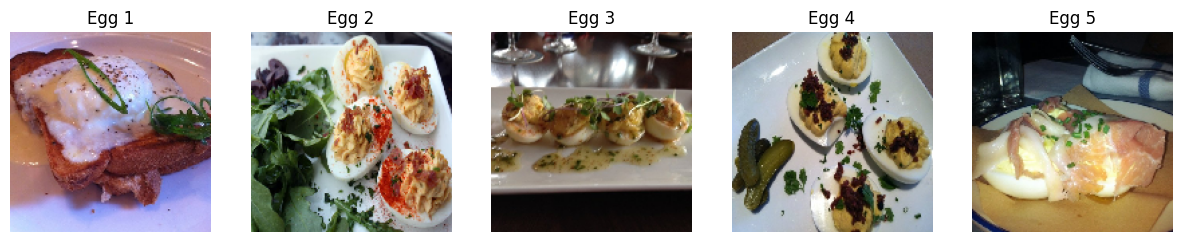

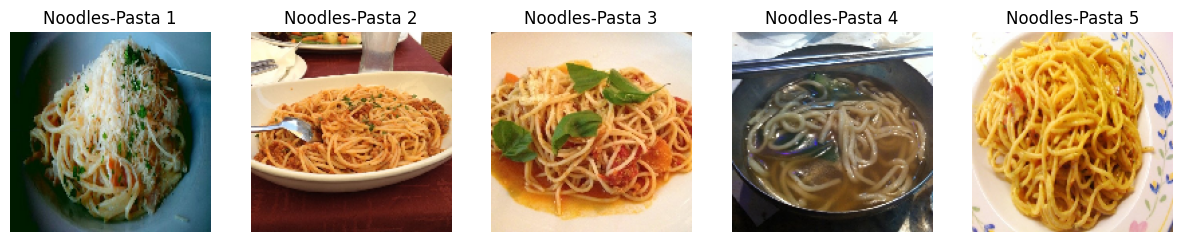

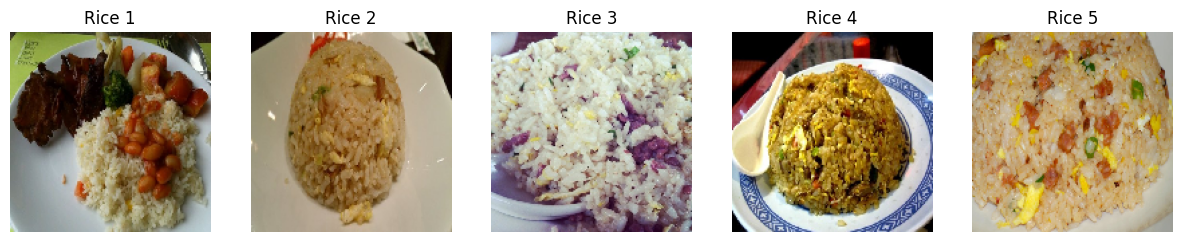

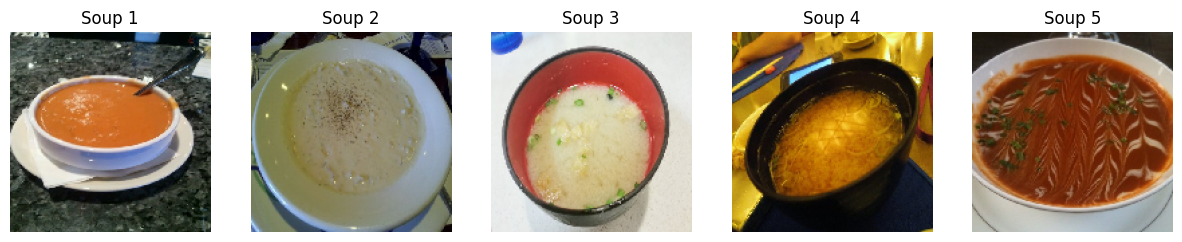

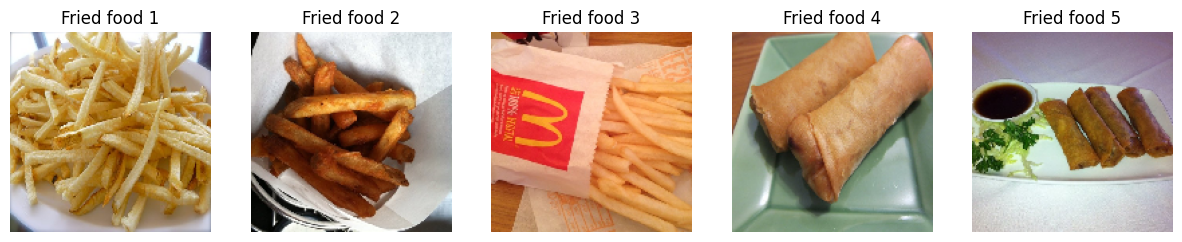

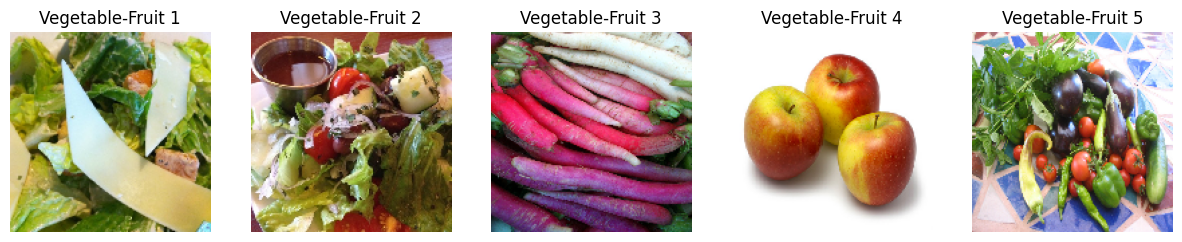

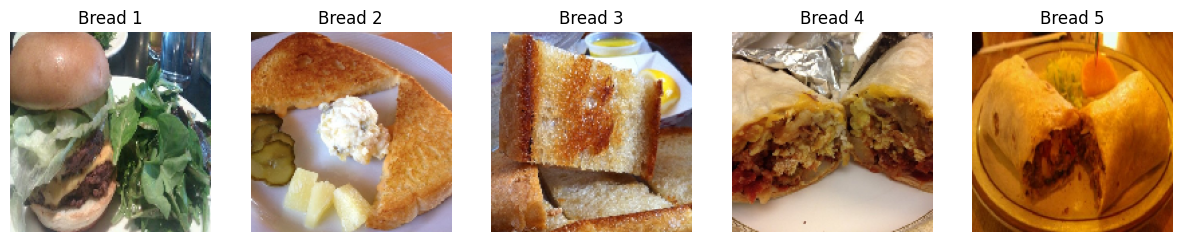

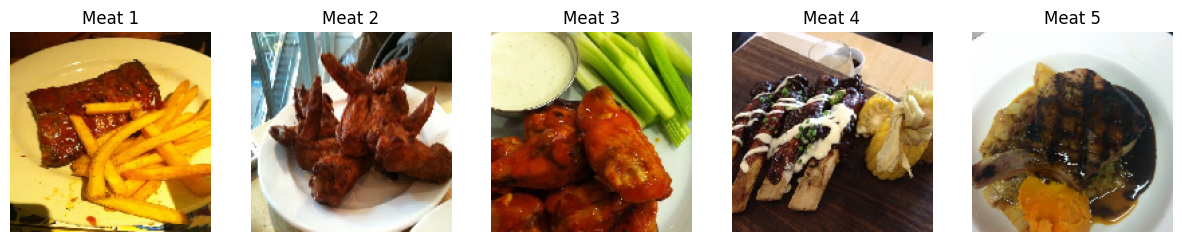

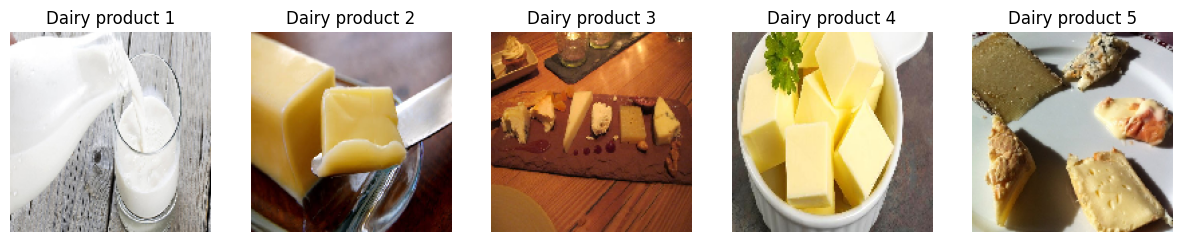

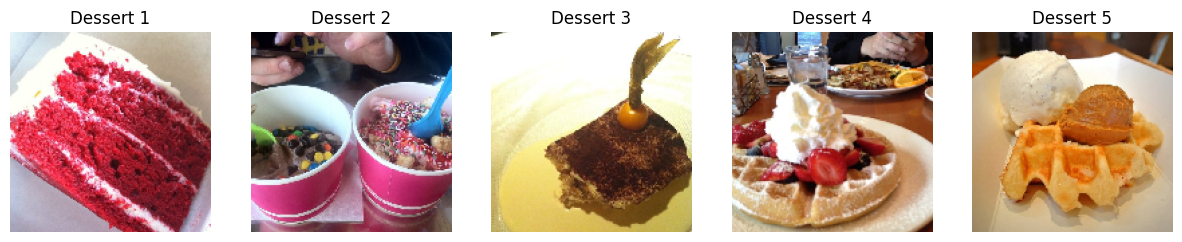

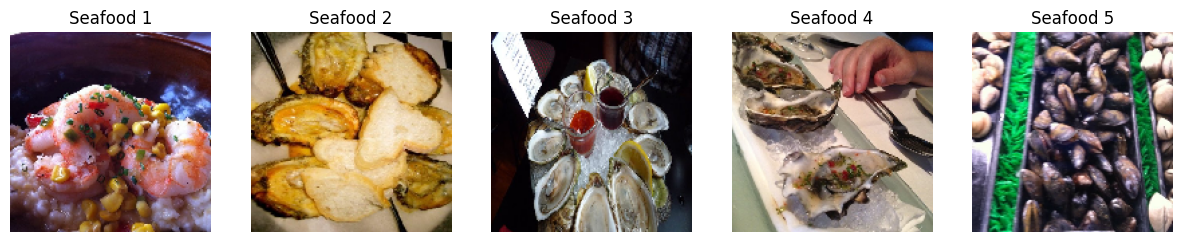

In [10]:
# Function to display images from multiple classes
def display_images_by_class(parent_folder, n_images=5):
    # Get the list of class folders
    class_folders = [f for f in os.listdir(parent_folder) if os.path.isdir(os.path.join(parent_folder, f))]

    for class_folder in class_folders:
        class_path = os.path.join(parent_folder, class_folder)
        images = os.listdir(class_path)[:n_images]
        plt.figure(figsize=(15, 10))
        for i, img_name in enumerate(images):
            img = load_img(os.path.join(class_path, img_name), target_size=(150, 150))
            plt.subplot(1, n_images, i + 1)
            plt.imshow(img)
            plt.title(f"{class_folder} {i+1}")
            plt.axis('off')
        plt.show()

# Path to the parent directory containing class folders
parent_folder = 'food11-image-dataset/training'

# Display images for each class in the parent folder
display_images_by_class(parent_folder, n_images=5)

# **Modeling**
----

In [11]:
model = Sequential()

model.add(Conv2D(32,(3,3),padding='same',activation='relu',input_shape = (image_size,image_size,3)))
model.add(MaxPooling2D((2,2),strides = 2 ,padding='same' ))

model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D((2,2),strides = 2 ,padding='same' ))

model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D((2,2),strides = 2 ,padding='same' ))

model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D((2,2),strides = 2 ,padding='same' ))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))

model.add(Dense(11,activation='softmax'))

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 11)             │           363 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 702,155 (2.68 MB)

 Trainable params: 702,155 (2.68 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
ES = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
RL = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [14]:
history = model.fit(train_generator,epochs=100,validation_data=val_generator, callbacks=[ES,RL])

Epoch 1/100
  1/309 ━━━━━━━━━━━━━━━━━━━━ 57:03 11s/step - accuracy: 0.0938 - loss: 2.4254

I0000 00:00:1724877136.684078      91 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1724877136.709563      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


231/309 ━━━━━━━━━━━━━━━━━━━━ 16s 210ms/step - accuracy: 0.1540 - loss: 2.3101

W0000 00:00:1724877185.065094      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


308/309 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.1595 - loss: 2.2994

W0000 00:00:1724877199.759395      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


309/309 ━━━━━━━━━━━━━━━━━━━━ 85s 241ms/step - accuracy: 0.1597 - loss: 2.2991 - val_accuracy: 0.2431 - val_loss: 2.0775 - learning_rate: 0.0010
Epoch 2/100


W0000 00:00:1724877210.973508      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


309/309 ━━━━━━━━━━━━━━━━━━━━ 70s 223ms/step - accuracy: 0.2421 - loss: 2.1006 - val_accuracy: 0.2790 - val_loss: 2.0346 - learning_rate: 0.0010
Epoch 3/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 70s 223ms/step - accuracy: 0.3002 - loss: 1.9619 - val_accuracy: 0.3714 - val_loss: 1.7712 - learning_rate: 0.0010
Epoch 4/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 70s 221ms/step - accuracy: 0.3599 - loss: 1.8259 - val_accuracy: 0.3991 - val_loss: 1.7762 - learning_rate: 0.0010
Epoch 5/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 70s 222ms/step - accuracy: 0.3942 - loss: 1.7558 - val_accuracy: 0.4012 - val_loss: 1.7283 - learning_rate: 0.0010
Epoch 6/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 70s 221ms/step - accuracy: 0.4487 - loss: 1.5969 - val_accuracy: 0.4679 - val_loss: 1.5594 - learning_rate: 0.0010
Epoch 7/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 69s 220ms/step - accuracy: 0.4690 - loss: 1.5463 - val_accuracy: 0.4280 - val_loss: 1.8077 - learning_rate: 0.0010
Epoch 8/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 70s 220ms/step - accuracy: 0.5000 -

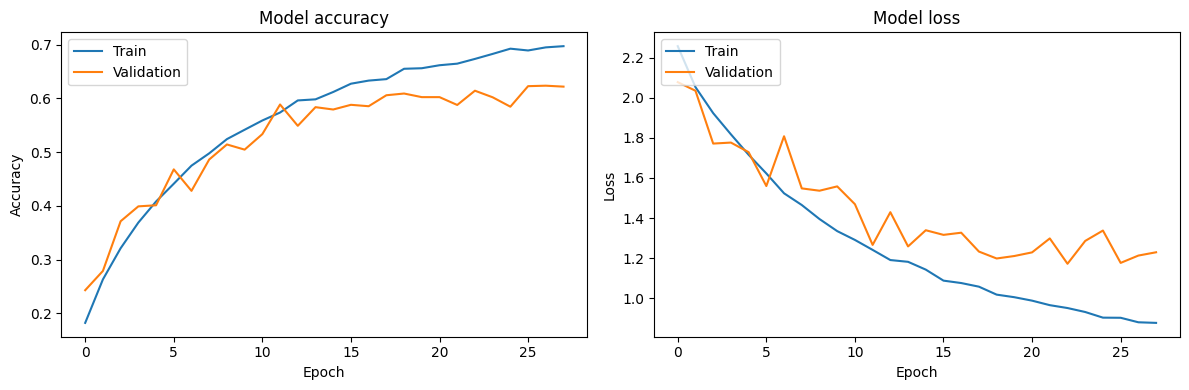

In [15]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


# **Evaluvation**
---

In [16]:
loss,acc = model.evaluate(train_generator,batch_size = 32, verbose = 0)
print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

loss,acc = model.evaluate(test_generator,batch_size = 32, verbose = 0)
print('The accuracy of the model for test data is:',acc*100)
print('The Loss of the model for test data is:',loss)

W0000 00:00:1724879146.083885      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


The accuracy of the model for training data is: 70.48449516296387
The Loss of the model for training data is: 0.8635292053222656
The accuracy of the model for test data is: 64.47564959526062
The Loss of the model for test data is: 1.087605595588684


W0000 00:00:1724879157.380069      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [17]:
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

  5/105 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step

W0000 00:00:1724879159.851757      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step


W0000 00:00:1724879169.782949      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


**Confusion Matrix**

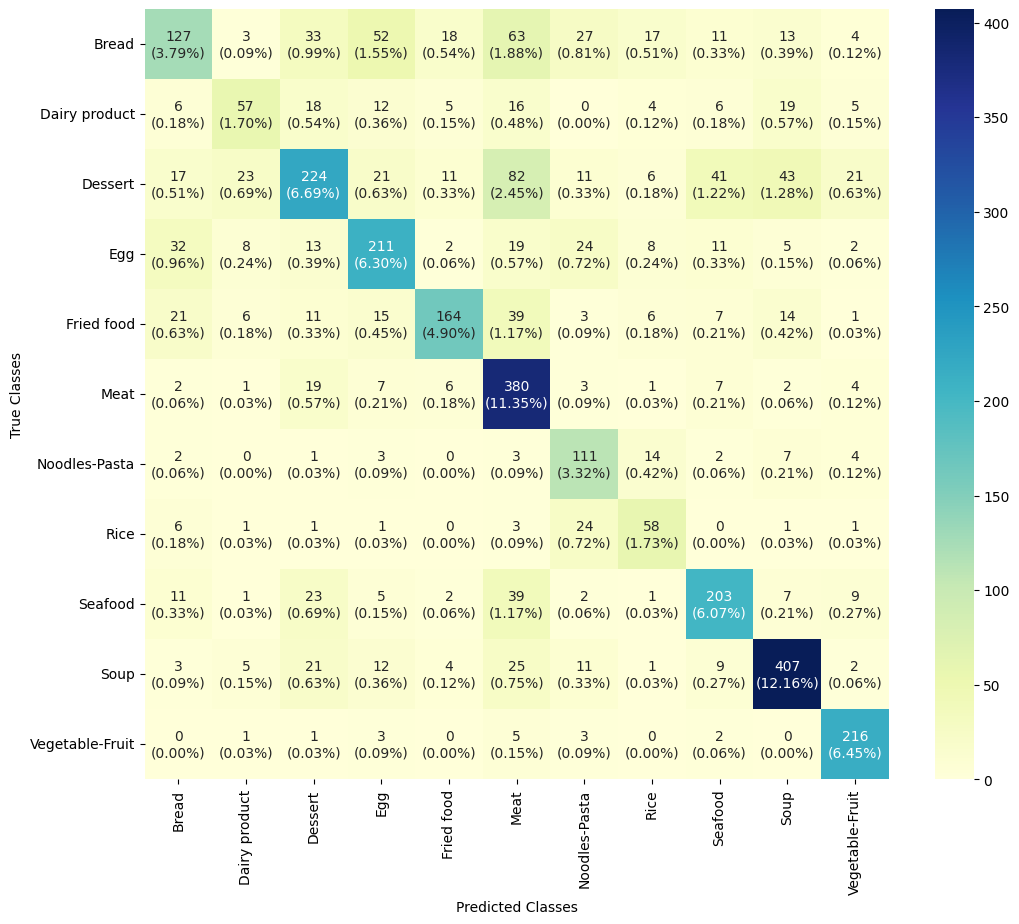

In [18]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(11, 11)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

**Classification Report**

In [19]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

                 precision    recall  f1-score   support

          Bread       0.56      0.35      0.43       368
  Dairy product       0.54      0.39      0.45       148
        Dessert       0.61      0.45      0.52       500
            Egg       0.62      0.63      0.62       335
     Fried food       0.77      0.57      0.66       287
           Meat       0.56      0.88      0.69       432
  Noodles-Pasta       0.51      0.76      0.61       147
           Rice       0.50      0.60      0.55        96
        Seafood       0.68      0.67      0.67       303
           Soup       0.79      0.81      0.80       500
Vegetable-Fruit       0.80      0.94      0.86       231

       accuracy                           0.64      3347
      macro avg       0.63      0.64      0.62      3347
   weighted avg       0.65      0.64      0.63      3347



**Display Some Images With Predictions**

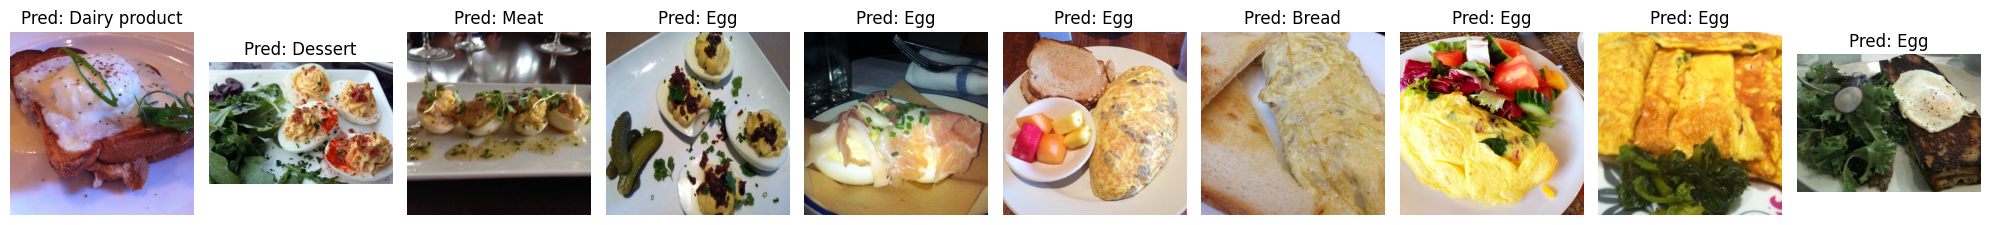

In [20]:
def display_images_with_predictions(generator, y_pred, num_images_to_display=10):
    # Get the class labels
    labels = {v: k for k, v in generator.class_indices.items()}

    # Get the filenames of the images
    filenames = generator.filenames

    # Create a subplot grid
    fig, axes = plt.subplots(1, num_images_to_display, figsize=(20, 4))

    for i in range(num_images_to_display):
        # Construct image path
        image_path = os.path.join(generator.directory, filenames[i])
        image = plt.imread(image_path)

        # Get predicted label
        predicted_label_idx = int(y_pred[i])
        predicted_label = labels[predicted_label_idx]

        # Display the image
        axes[i].imshow(image)
        axes[i].set_title(f"Pred: {predicted_label}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


# Call the function
display_images_with_predictions(train_generator, y_pred, num_images_to_display=10)
